<a href="https://colab.research.google.com/github/maik1105/US-Treasury-Constant-Maturities/blob/main/US_Treasury_Constant_Maturities.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#The project downloads historical data from the US Federal Reserve rates year over year.
#Utilizes data analysis tools and machine learning neural networks with Tensor Flow to emulate the data
#Download the corresponding packages
import requests
import zipfile
import io
import xml.etree.ElementTree as ET

In [ ]:
#Download the H15 Federal Reserve data which is on SDMX zip file
url = "https://www.federalreserve.gov/datadownload/Output.aspx?rel=H15&filetype=zip"
response = requests.get(url)

In [ ]:
#Open ZIP file in memory
with zipfile.ZipFile(io.BytesIO(response.content)) as z:
  #List of contents to find the SDMX file
  print("Files in ZIP:", z.namelist())

  #Open the SDMX-ML file (usually ends in .xml)
  with z.open('H15_data.xml') as f:
    tree = ET.parse(f)
    root = tree.getroot()

Files in ZIP: ['H15_discontinued.xsd', 'H15_H15.xsd', 'H15_data.xml', 'H15_struct.xml', 'frb_common.xsd']


In [ ]:
#Explore the XML structure
#Print the first few elements to understand the structure
for child in root[:5]:
  print(child.tag, child.attrib)

{http://www.SDMX.org/resources/SDMXML/schemas/v1_0/message}Header {}
{http://www.federalreserve.gov/structure/compact/common}DataSet {'id': 'H15', '{http://www.w3.org/2001/XMLSchema-instance}schemaLocation': 'http://www.federalreserve.gov/structure/compact/H15_H15 H15_H15.xsd'}
{http://www.federalreserve.gov/structure/compact/common}DataSet {'id': 'discontinued', '{http://www.w3.org/2001/XMLSchema-instance}schemaLocation': 'http://www.federalreserve.gov/structure/compact/H15_discontinued H15_discontinued.xsd'}


In [ ]:
#Lets extract the FED Interest Rate data
#XML file uses SDMX namespaces and contains two main dataset elements: one for active H.1 data and one for discontinued series. Let's extract usable data from the active dataset
import pandas as pd

#Define namespaces
ns = {
    'mes': 'http://www.SDMX.org/resources/SDMXML/schemas/v1_0/message',
    'com': 'http://www.federalreserve.gov/structure/compact/common'
}

#Find the active dataset
dataset = root.find('.//com:DataSet[@id="H15"]', ns)
print(type(dataset))  # Should be Element, not None

<class 'xml.etree.ElementTree.Element'>


In [ ]:
#Check the root were the data is really. This step is to revise where the data really is as first the parse was not really
#downloadind the dat as it was deeper in the /DataSet folder. After realizing this, the 'com" label in the 'ns' namespace had to be corrected
for elem in dataset.iter():
    print(elem.tag)
    break  # Just show the first one

{http://www.federalreserve.gov/structure/compact/common}DataSet


In [ ]:
#After he previous code, the data is inside the "http://www.federalreserve.gov/structure/compact/common}DataSet"
#We need to dig deeper into the data to extract the real information
tags = set()
for elem in dataset.iter():
    tags.add(elem.tag)

for tag in tags:
    print(tag)

{http://www.SDMX.org/resources/SDMXML/schemas/v1_0/common}Annotation
{http://www.federalreserve.gov/structure/compact/common}Annotations
{http://www.SDMX.org/resources/SDMXML/schemas/v1_0/common}AnnotationText
{http://www.federalreserve.gov/structure/compact/common}DataSet
{http://www.SDMX.org/resources/SDMXML/schemas/v1_0/common}AnnotationType
{http://www.federalreserve.gov/structure/compact/H15_H15}Series
{http://www.federalreserve.gov/structure/compact/common}Obs


In [ ]:
#Correcting the namespaces, so the parser nows where to find exactly the data.
ns = {
    'com': 'http://www.federalreserve.gov/structure/compact/common',
    'h15': 'http://www.federalreserve.gov/structure/compact/H15_H15'
}

In [ ]:
#Extracting the atributes as SERIES, OBSERVATIONS AND DATES
records = []

for series in dataset.findall('.//h15:Series', ns):
    series_id = series.attrib.get('SERIES_NAME', 'unknown')

    for obs in series.findall('com:Obs', ns):
        date = obs.attrib.get('TIME_PERIOD')
        value = obs.attrib.get('OBS_VALUE')

        if date and value:
            records.append({
                'series': series_id,
                'date': date,
                'value': float(value)
            })

In [ ]:
#Now that we have the data lets pass it to a Pandas dataframe for manupulation
import pandas as pd

df = pd.DataFrame(records)
df['value'] = pd.to_numeric(df['value'], errors='coerce')
df['date'] = pd.to_datetime(df['date'])

display(df.head())


,series,date,value
0,RIFSPFF_N.B,1954-07-01,1.13
1,RIFSPFF_N.B,1954-07-02,1.25
2,RIFSPFF_N.B,1954-07-05,0.88
3,RIFSPFF_N.B,1954-07-06,0.25
4,RIFSPFF_N.B,1954-07-07,1.00


In [ ]:
#Verify the attributes of the data.
for series in dataset.findall('.//h15:Series', ns):
    print(series.attrib)
    break  # Just show one

{'CURRENCY': 'NA', 'FREQ': '9', 'INSTRUMENT': 'FF', 'MATURITY': 'O', 'SERIES_NAME': 'RIFSPFF_N.B', 'UNIT': 'Percent:_Per_Year', 'UNIT_MULT': '1'}


In [ ]:
df.groupby('series')['value'].describe()

,count,mean,std,min,25%,50%,75%,max
series,,,,,,,,
RIFLGFCM01_N.A,24.0,1.575417,1.748582,0.03,0.0925,1.145,2.2075,5.27
RIFLGFCM01_N.B,6273.0,-414.469893,1997.176217,-9999.00,0.0600,0.900,2.4200,6.02
RIFLGFCM01_N.M,289.0,1.627093,1.818023,0.00,0.0800,0.970,2.6100,5.57
RIFLGFCM01_N.WF,1254.0,1.624506,1.820033,0.00,0.0725,0.960,2.4600,5.81
RIFLGFCM03_N.A,44.0,3.967500,3.327733,0.03,1.0100,3.940,5.7350,13.19
...,...,...,...,...,...,...,...,...
RIFSRP_F02_N.A,21.0,2.227619,1.927140,0.25,0.7500,1.600,2.7800,5.96
RIFSRP_F02_N.B,5896.0,2.284812,1.908839,0.25,0.7500,1.750,3.5000,6.25
RIFSRP_F02_N.D,8254.0,2.285044,1.908466,0.25,0.7500,1.750,3.5000,6.25


In [ ]:
df['series'].nunique()

124

In [ ]:
df['series'].unique()

array(['RIFSPFF_N.B', 'RIFSPFF_N.D', 'RIFSPFF_N.WW', 'RIFSPFF_N.BWAW',
       'RIFSPFF_N.M', 'RIFSPFF_N.A', 'RIFSPPNAAD30_N.B',
       'RIFSPPNAAD30_N.WF', 'RIFSPPNAAD30_N.M', 'RIFSPPNAAD30_N.A',
       'RIFSPPNAAD60_N.B', 'RIFSPPNAAD60_N.WF', 'RIFSPPNAAD60_N.M',
       'RIFSPPNAAD60_N.A', 'RIFSPPNAAD90_N.B', 'RIFSPPNAAD90_N.WF',
       'RIFSPPNAAD90_N.M', 'RIFSPPNAAD90_N.A', 'RIFSPPFAAD30_N.B',
       'RIFSPPFAAD30_N.WF', 'RIFSPPFAAD30_N.M', 'RIFSPPFAAD30_N.A',
       'RIFSPPFAAD60_N.B', 'RIFSPPFAAD60_N.WF', 'RIFSPPFAAD60_N.M',
       'RIFSPPFAAD60_N.A', 'RIFSPPFAAD90_N.B', 'RIFSPPFAAD90_N.WF',
       'RIFSPPFAAD90_N.M', 'RIFSPPFAAD90_N.A', 'RIFSPBLP_N.B',
       'RIFSPBLP_N.D', 'RIFSPBLP_N.WW', 'RIFSPBLP_N.M', 'RIFSPBLP_N.A',
       'RIFSRP_F02_N.B', 'RIFSRP_F02_N.D', 'RIFSRP_F02_N.WW',
       'RIFSRP_F02_N.M', 'RIFSRP_F02_N.A', 'RIFSGFSW04_N.B',
       'RIFSGFSW04_N.WF', 'RIFSGFSW04_N.M', 'RIFSGFSW04_N.A',
       'RIFSGFSM03_N.B', 'RIFSGFSM03_N.WF', 'RIFSGFSM03_N.M',
       'RIFSGFS

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 479125 entries, 0 to 479124
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   series  479125 non-null  object        
 1   date    479125 non-null  datetime64[ns]
 2   value   479125 non-null  float64       
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 11.0+ MB


In [ ]:
df.isnull().sum()

,0
series,0
date,0
value,0


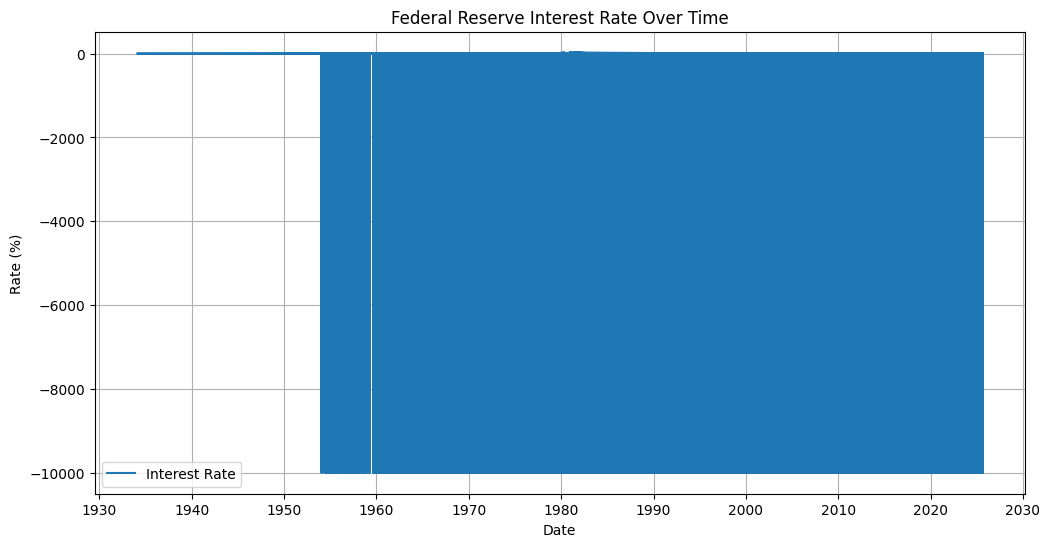

In [ ]:
#Let's print the rates time graph for a quick snippet
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(df['date'], df['value'], label='Interest Rate')
plt.title('Federal Reserve Interest Rate Over Time')
plt.xlabel('Date')
plt.ylabel('Rate (%)')
plt.grid(True)
plt.legend()
plt.show()

In [ ]:
#The graph does not make sense as there should be a progression increasing or decreasing the rate per year
#There are negative outliers with big values
df['value'].describe()
df[df['value'] < 0].sort_values('value').head(10)

,series,date,value
293926,RIFLGFCY01_N.B,2006-05-29,-9999.0
294446,RIFLGFCY01_N.B,2008-05-26,-9999.0
293666,RIFLGFCY01_N.B,2005-05-30,-9999.0
293691,RIFLGFCY01_N.B,2005-07-04,-9999.0
293736,RIFLGFCY01_N.B,2005-09-05,-9999.0
293761,RIFLGFCY01_N.B,2005-10-10,-9999.0
293785,RIFLGFCY01_N.B,2005-11-11,-9999.0
293794,RIFLGFCY01_N.B,2005-11-24,-9999.0
293816,RIFLGFCY01_N.B,2005-12-26,-9999.0
293821,RIFLGFCY01_N.B,2006-01-02,-9999.0


In [ ]:
df['value'].describe()

,value
count,479125.000000
mean,-510.521797
std,2210.262317
min,-9999.000000
25%,1.090000
50%,3.940000
75%,6.030000
max,22.360000


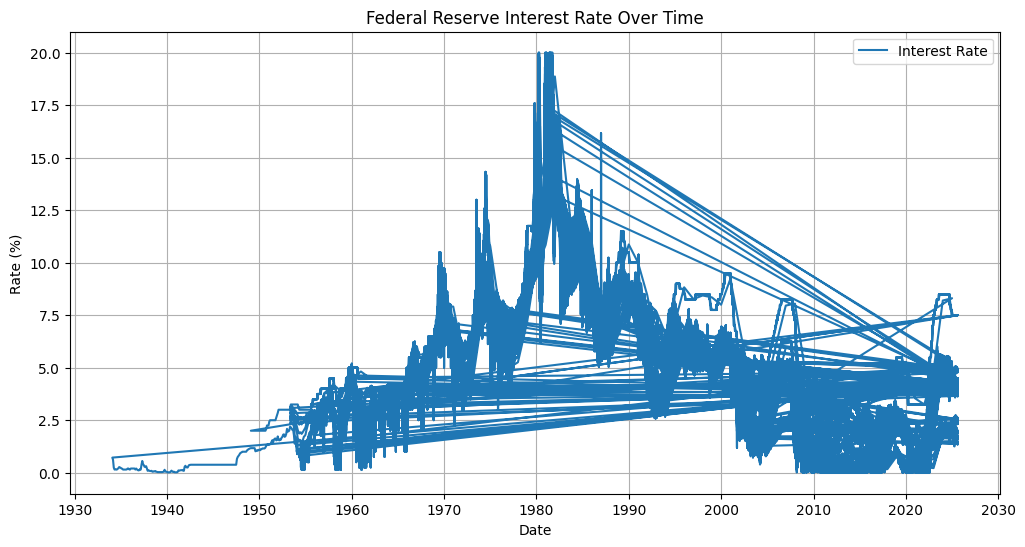

In [ ]:
#The graph is showing extreme values of -9999. Lets print another graph limting the values

filtered_df = df[(df['value'] >= 0) & (df['value'] <= 20)]

plt.figure(figsize=(12, 6))
plt.plot(filtered_df['date'], filtered_df['value'], label='Interest Rate')
plt.title('Federal Reserve Interest Rate Over Time')
plt.xlabel('Date')
plt.ylabel('Rate (%)')
plt.grid(True)
plt.legend()
plt.show()

In [ ]:
#Lets drop the outlier values
df = df[(df['value'] >= 0) & (df['value'] <= 20)]

In [ ]:
#The graph looks "Cleaner", however more work needs to be done as it is overlaping all of the labels
#Lets classify into a human readable label all the labels
#We need federal rate definitions as they are coded in the dataframe.

import re
series_codes = [
    'RIFSPFF_N.B', 'RIFSPFF_N.D', 'RIFSPFF_N.WW', 'RIFSPFF_N.BWAW',
    'RIFSPFF_N.M', 'RIFSPFF_N.A', 'RIFSPPNAAD30_N.B', 'RIFSPPNAAD30_N.WF',
    'RIFSPPNAAD30_N.M', 'RIFSPPNAAD30_N.A', 'RIFSPPNAAD60_N.B', 'RIFSPPNAAD60_N.WF',
    'RIFSPPNAAD60_N.M', 'RIFSPPNAAD60_N.A', 'RIFSPPNAAD90_N.B', 'RIFSPPNAAD90_N.WF',
    'RIFSPPNAAD90_N.M', 'RIFSPPNAAD90_N.A', 'RIFSPPFAAD30_N.B', 'RIFSPPFAAD30_N.WF',
    'RIFSPPFAAD30_N.M', 'RIFSPPFAAD30_N.A', 'RIFSPPFAAD60_N.B', 'RIFSPPFAAD60_N.WF',
    'RIFSPPFAAD60_N.M', 'RIFSPPFAAD60_N.A', 'RIFSPPFAAD90_N.B', 'RIFSPPFAAD90_N.WF',
    'RIFSPPFAAD90_N.M', 'RIFSPPFAAD90_N.A', 'RIFSPBLP_N.B', 'RIFSPBLP_N.D',
    'RIFSPBLP_N.WW', 'RIFSPBLP_N.M', 'RIFSPBLP_N.A', 'RIFSRP_F02_N.B', 'RIFSRP_F02_N.D',
    'RIFSRP_F02_N.WW', 'RIFSRP_F02_N.M', 'RIFSRP_F02_N.A', 'RIFSGFSW04_N.B',
    'RIFSGFSW04_N.WF', 'RIFSGFSW04_N.M', 'RIFSGFSW04_N.A', 'RIFSGFSM03_N.B',
    'RIFSGFSM03_N.WF', 'RIFSGFSM03_N.M', 'RIFSGFSM03_N.A', 'RIFSGFSM06_N.B',
    'RIFSGFSM06_N.WF', 'RIFSGFSM06_N.M', 'RIFSGFSM06_N.A', 'RIFSGFSY01_N.B',
    'RIFSGFSY01_N.WF', 'RIFSGFSY01_N.M', 'RIFSGFSY01_N.A', 'RIFLGFCM01_N.B',
    'RIFLGFCM01_N.WF', 'RIFLGFCM01_N.M', 'RIFLGFCM01_N.A', 'RIFLGFCM03_N.B',
    'RIFLGFCM03_N.WF', 'RIFLGFCM03_N.M', 'RIFLGFCM03_N.A', 'RIFLGFCM06_N.B',
    'RIFLGFCM06_N.WF', 'RIFLGFCM06_N.M', 'RIFLGFCM06_N.A', 'RIFLGFCY01_N.B',
    'RIFLGFCY01_N.WF', 'RIFLGFCY01_N.M', 'RIFLGFCY01_N.A', 'RIFLGFCY02_N.B',
    'RIFLGFCY02_N.WF', 'RIFLGFCY02_N.M', 'RIFLGFCY02_N.A', 'RIFLGFCY03_N.B',
    'RIFLGFCY03_N.WF', 'RIFLGFCY03_N.M', 'RIFLGFCY03_N.A', 'RIFLGFCY05_N.B',
    'RIFLGFCY05_N.WF', 'RIFLGFCY05_N.M', 'RIFLGFCY05_N.A', 'RIFLGFCY07_N.B',
    'RIFLGFCY07_N.WF', 'RIFLGFCY07_N.M', 'RIFLGFCY07_N.A', 'RIFLGFCY10_N.B',
    'RIFLGFCY10_N.WF', 'RIFLGFCY10_N.M', 'RIFLGFCY10_N.A', 'RIFLGFCY20_N.B',
    'RIFLGFCY20_N.WF', 'RIFLGFCY20_N.M', 'RIFLGFCY20_N.A', 'RIFLGFCY30_N.B',
    'RIFLGFCY30_N.WF', 'RIFLGFCY30_N.M', 'RIFLGFCY30_N.A', 'RIFLGFCY05_XII_N.B',
    'RIFLGFCY05_XII_N.WF', 'RIFLGFCY05_XII_N.M', 'RIFLGFCY05_XII_N.A',
    'RIFLGFCY07_XII_N.B', 'RIFLGFCY07_XII_N.WF', 'RIFLGFCY07_XII_N.M',
    'RIFLGFCY07_XII_N.A', 'RIFLGFCY10_XII_N.B', 'RIFLGFCY10_XII_N.WF',
    'RIFLGFCY10_XII_N.M', 'RIFLGFCY10_XII_N.A', 'RIFLGFCY20_XII_N.B',
    'RIFLGFCY20_XII_N.WF', 'RIFLGFCY20_XII_N.M', 'RIFLGFCY20_XII_N.A',
    'RIFLGFCY30_XII_N.B', 'RIFLGFCY30_XII_N.WF', 'RIFLGFCY30_XII_N.M',
    'RIFLGFCY30_XII_N.A', 'RIFLGFL_XII_N.B', 'RIFLGFL_XII_N.WF',
    'RIFLGFL_XII_N.M', 'RIFLGFL_XII_N.A'
]
# Frequency mapping
freq_map = {
    'N.B': 'Business Daily',
    'N.D': 'Daily',
    'N.WW': 'Weekly (Wednesday)',
    'N.BWAW': 'Weekly (Average)',
    'N.WF': 'Weekly (Friday)',
    'N.M': 'Monthly',
    'N.A': 'Annual'
}



In [ ]:
def decode_label(code):
    base, freq = code.rsplit('_', 1)
    freq_label = freq_map.get(freq, freq)

    # Extract components
    parts = base.split('_')
    prefix = parts[0]
    modifier = parts[1] if len(parts) > 1 else ''

    # Custom label logic
    label = ''
    if prefix.startswith('RIFSPFF'):
        label = 'Federal Funds Rate'
    elif prefix.startswith('RIFSPPNAAD'):
        label = f'Prime Rate - New Auto Loans ({prefix[-2:]} Days)'
    elif prefix.startswith('RIFSPPFAAD'):
        label = f'Prime Rate - Fixed Auto Loans ({prefix[-2:]} Days)'
    elif prefix.startswith('RIFSPBLP'):
        label = 'Bank Loan Prime Rate'
    elif prefix.startswith('RIFSRP_F02'):
        label = 'Retail Prime Loan Rate'
    elif prefix.startswith('RIFSGFSW04'):
        label = 'Government Securities - SW04'
    elif prefix.startswith('RIFSGFSM03'):
        label = 'Government Securities - SM03'
    elif prefix.startswith('RIFSGFSM06'):
        label = 'Government Securities - SM06'
    elif prefix.startswith('RIFSGFSY01'):
        label = 'Government Securities - SY01'
    elif prefix.startswith('RIFLGFCM'):
        label = f'Long-Term Government Forecast - Maturity {prefix[-2:]}'
    elif prefix.startswith('RIFLGFCY'):
        maturity = re.search(r'\d+', prefix)
        label = f'Long-Term Government Forecast - Yield {maturity.group()}'
        if 'XII' in prefix:
            label += ' (Scenario XII)'
    elif prefix.startswith('RIFLGFL'):
        label = 'Long-Term Government Forecast - Liquidity'
        if 'XII' in prefix:
            label += ' (Scenario XII)'
    else:
        label = prefix

    return f'{label} ({freq_label})'

In [ ]:
# Build DataFrame
df_readable_labels = pd.DataFrame({
    'Series Code': series_codes,
    'Label': [decode_label(code) for code in series_codes]
})

In [ ]:
df_readable_labels[:124]

,Series Code,Label
0,RIFSPFF_N.B,Federal Funds Rate (Business Daily)
1,RIFSPFF_N.D,Federal Funds Rate (Daily)
2,RIFSPFF_N.WW,Federal Funds Rate (Weekly (Wednesday))
3,RIFSPFF_N.BWAW,Federal Funds Rate (Weekly (Average))
4,RIFSPFF_N.M,Federal Funds Rate (Monthly)
...,...,...
119,RIFLGFCY30_XII_N.A,Long-Term Government Forecast - Yield 30 (Annual)
120,RIFLGFL_XII_N.B,Long-Term Government Forecast - Liquidity (Bus...
121,RIFLGFL_XII_N.WF,Long-Term Government Forecast - Liquidity (Wee...
122,RIFLGFL_XII_N.M,Long-Term Government Forecast - Liquidity (Mon...


In [ ]:
df

,series,date,value
0,RIFSPFF_N.B,1954-07-01,1.13
1,RIFSPFF_N.B,1954-07-02,1.25
2,RIFSPFF_N.B,1954-07-05,0.88
3,RIFSPFF_N.B,1954-07-06,0.25
4,RIFSPFF_N.B,1954-07-07,1.00
...,...,...,...
479118,RIFLGFL_XII_N.A,2018-12-31,0.97
479119,RIFLGFL_XII_N.A,2019-12-31,0.73
479122,RIFLGFL_XII_N.A,2022-12-31,0.85
479123,RIFLGFL_XII_N.A,2023-12-31,1.87


In [ ]:
#We have correctly labeled the series codes, however going back to the evolution over time, all the
#series overlap between them, making the plot looking dirty
focus_series = [
    'RIFSPFF_N.B',        # Federal Funds Rate – Business Daily
    'RIFLGFCY10_N.M',     # 10-Year Treasury Yield – Monthly
    'RIFLGFCY30_N.A'      # 30-Year Treasury Yield – Annual
]

df_focus = df[df['series'].isin(focus_series)]

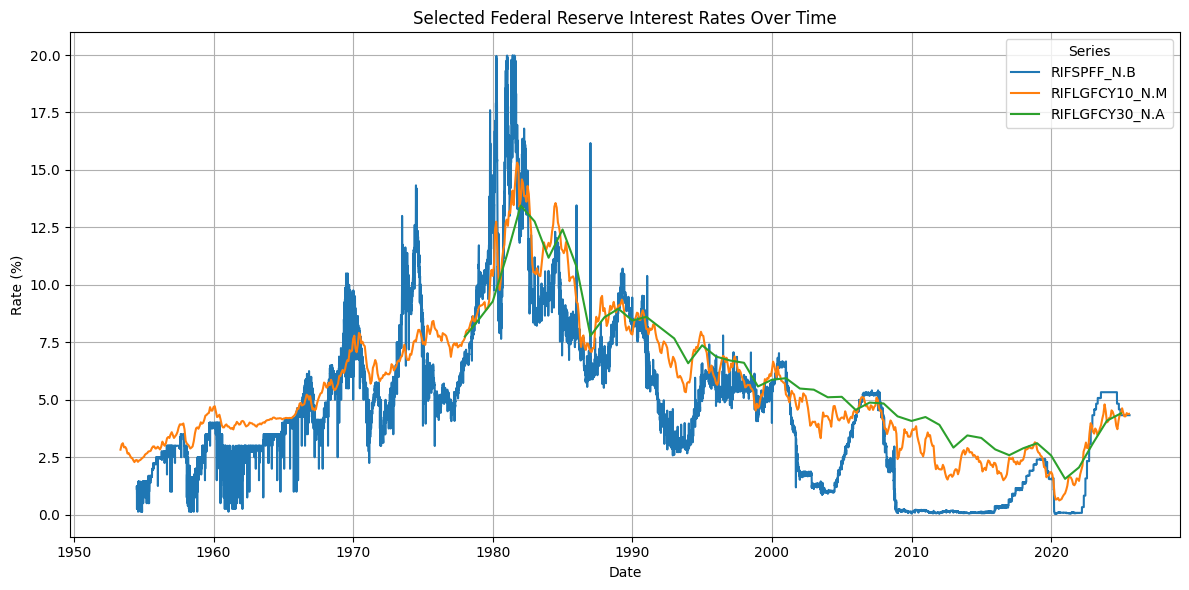

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 6))
sns.lineplot(data=df_focus, x='date', y='value', hue='series')
plt.title('Selected Federal Reserve Interest Rates Over Time')
plt.xlabel('Date')
plt.ylabel('Rate (%)')
plt.legend(title='Series')
plt.grid(True)
plt.tight_layout()
plt.show()

#We were able to create a cleaner visualization, focusing on 3 parameters

In [ ]:
#We will now apply Machine Learning techniques to try to predict the following 10-Year-Treasury rate for the next years
#Filtering the series -- rates

target_series = 'RIFLGFCY10_N.M'
df_target = df[df['series'] == target_series].copy()
df_target.sort_values('date', inplace=True)


In [ ]:
#Normalize the values
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
df_target['scaled'] = scaler.fit_transform(df_target[['value']])

In [ ]:
#Creating sequences
#Defining parameters
import numpy as np
sequence_length = 12 #we will use past 12 months to predict
data = df_target['scaled'].values

X, y = [],[]
for i in range(len(data) - sequence_length):
  X.append(data[i:i+sequence_length])
  y.append(data[i+sequence_length])

X = np.array(X)
y = np.array(y)

#Reshape for LSTM: [samples, time steps, features]
X = X.reshape((X.shape[0], X.shape[1], 1))

In [ ]:
#Build the LSTM model
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

model = Sequential([
    LSTM(50, activation = 'relu', input_shape=(sequence_length, 1)),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse')

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
#Model Train

history = model.fit(X, epochs=0, batch_size=16, verbose=1)

In [ ]:
#Make predictions
predictions = model.predict(X)
predicted_values = scaler.inverse_transform(predictions)

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


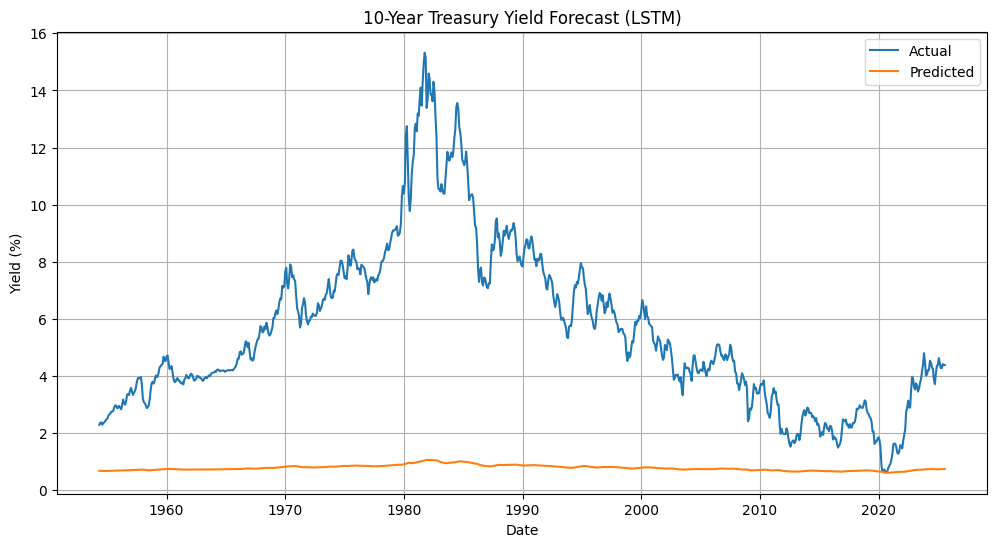

In [ ]:
#Prediction visualization

plt.figure(figsize=(12, 6))
plt.plot(df_target['date'][sequence_length:], df_target['value'][sequence_length:], label='Actual')
plt.plot(df_target['date'][sequence_length:], predicted_values, label='Predicted')
plt.title('10-Year Treasury Yield Forecast (LSTM)')
plt.xlabel('Date')
plt.ylabel('Yield (%)')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
#The prediction is underfitting as it does not emulates the original data
#We will split the data into training and testing data in order to apply a different technique

cutoff_date = '2000-01-01'
train_df = df_target[df_target['date'] < cutoff_date]
test_df = df_target[df_target['date'] >= cutoff_date]

In [ ]:
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train_df[['value']])
test_scaled = scaler.transform(test_df[['value']])

In [ ]:
#Create sequences for training
def create_sequences(data, seq_len):
  X, y = [], []
  data = data.flatten()
  for i in range(len(data) - seq_len):
    X.append(data[i:i+seq_len])
    y.append(data[i+seq_len])
  return np.array(X), np.array(y)

sequence_length = 12
X_train, y_train = create_sequences(train_scaled, sequence_length)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))

In [ ]:
#Train model
model = Sequential([
    LSTM(50, activation='relu', input_shape=(sequence_length, 1)),
    Dense(1)
])
model.compile(optimizer='adam', loss='mse')
model.fit(X_train, y_train, epochs=50, batch_size=16, verbose=1)

Epoch 1/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0805
Epoch 2/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0060
Epoch 3/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0028
Epoch 4/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0023
Epoch 5/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0018
Epoch 6/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0022
Epoch 7/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0022
Epoch 8/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0021
Epoch 9/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0018
Epoch 10/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0023
Epoch 11/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0019
Epoch 12/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0018
Epoch 13/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0019
Epoch 14/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0015
Epoch 15/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0017
Epoch 16/50
35/35 

In [ ]:
#Create test sequences
X_test, y_test = create_sequences(test_scaled, sequence_length)
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

In [ ]:
#Predict and invert scaling
predictions = model.predict(X_test)
predicted_values = scaler.inverse_transform(predictions)
actual_values = scaler.inverse_transform(y_test.reshape(-1, 1))

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


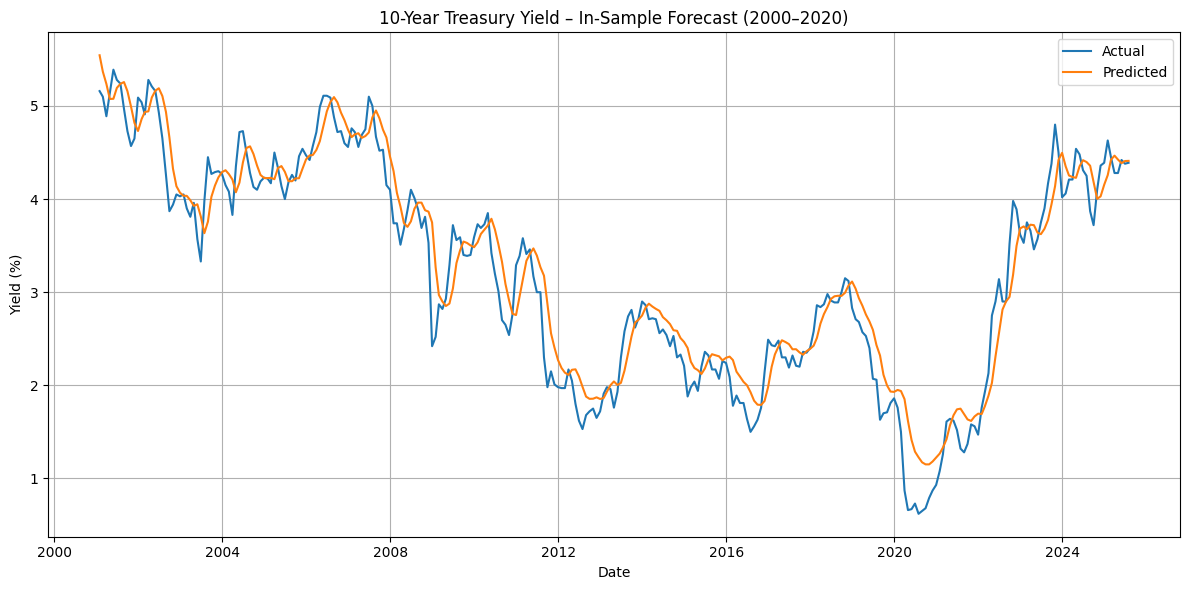

In [ ]:
test_dates = test_df['date'].values[sequence_length:]

plt.figure(figsize=(12, 6))
plt.plot(test_dates, actual_values, label='Actual')
plt.plot(test_dates, predicted_values, label='Predicted')
plt.title('10-Year Treasury Yield – In-Sample Forecast (2000–2020)')
plt.xlabel('Date')
plt.ylabel('Yield (%)')
plt.legend()
plt.grid(True)
plt.tight_layout()

#With this new approach the model predicted more accurately the real data.